In [34]:
import requests
import pandas as pd

# Coordonnées Benguerir
lat, lon = 32.2319, -7.9351

# Dates
start = '2024-07-01'
end = '2025-07-01'

# Variables d'intérêt (voir documentation NASA POWER pour la liste complète)
vars = [
    'T2M_MAX',  # Température max (°C)
    'T2M_MIN',  # Température min (°C)
    'PRECTOT',  # Précipitation (mm)
    'RH2M',     # Humidité relative (%)
    'WS2M',     # Vent à 2m (m/s)
    'ALLSKY_SFC_SW_DWN',  # Rayonnement global (W/m2)
]

api_url = (
    "https://power.larc.nasa.gov/api/temporal/daily/point"
    f"?start={start.replace('-', '')}&end={end.replace('-', '')}"
    f"&latitude={lat}&longitude={lon}"
    f"&community=AG&parameters={','.join(vars)}"
    "&format=CSV"
)

print("Requête :", api_url)
response = requests.get(api_url)
with open("nasa_power_benguerir.csv") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if line.startswith("YEAR,"):
            skiprows = i
            break

df = pd.read_csv("nasa_power_benguerir.csv", skiprows=skiprows)
print(df.head())


Requête : https://power.larc.nasa.gov/api/temporal/daily/point?start=20240701&end=20250701&latitude=32.2319&longitude=-7.9351&community=AG&parameters=T2M_MAX,T2M_MIN,PRECTOT,RH2M,WS2M,ALLSKY_SFC_SW_DWN&format=CSV
   YEAR  DOY  ALLSKY_SFC_SW_DWN  WS2M  T2M_MAX   RH2M  T2M_MIN  PRECTOTCORR
0  2024  183              31.10  3.94    34.94  48.62    16.99          0.0
1  2024  184              31.00  2.95    37.54  47.38    16.42          0.0
2  2024  185              30.20  2.54    37.70  43.85    17.01          0.0
3  2024  186              29.84  3.13    37.89  46.20    18.36          0.0
4  2024  187              29.45  3.46    34.61  53.46    17.74          0.0


In [35]:
df["date"] = pd.to_datetime(df["YEAR"].astype(str)) + pd.to_timedelta(df["DOY"] - 1, unit="D")
print(df[["date", "T2M_MAX", "T2M_MIN", "RH2M", "WS2M", "ALLSKY_SFC_SW_DWN", "PRECTOTCORR"]].head())


        date  T2M_MAX  T2M_MIN   RH2M  WS2M  ALLSKY_SFC_SW_DWN  PRECTOTCORR
0 2024-07-01    34.94    16.99  48.62  3.94              31.10          0.0
1 2024-07-02    37.54    16.42  47.38  2.95              31.00          0.0
2 2024-07-03    37.70    17.01  43.85  2.54              30.20          0.0
3 2024-07-04    37.89    18.36  46.20  3.13              29.84          0.0
4 2024-07-05    34.61    17.74  53.46  3.46              29.45          0.0


In [36]:
import pandas as pd

# Chargement des données météo
with open("nasa_power_benguerir.csv") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if line.startswith("YEAR,"):
            skiprows = i
            break

meteo = pd.read_csv("nasa_power_benguerir.csv", skiprows=skiprows)

# Chargement des données de production/cout par technique
techniques = pd.read_csv('production_cout_techniques.csv')

print("Aperçu données météo :")
print(meteo.head())

print("\nAperçu données techniques :")
print(techniques.head())


Aperçu données météo :
   YEAR  DOY  ALLSKY_SFC_SW_DWN  WS2M  T2M_MAX   RH2M  T2M_MIN  PRECTOTCORR
0  2024  183              31.10  3.94    34.94  48.62    16.99          0.0
1  2024  184              31.00  2.95    37.54  47.38    16.42          0.0
2  2024  185              30.20  2.54    37.70  43.85    17.01          0.0
3  2024  186              29.84  3.13    37.89  46.20    18.36          0.0
4  2024  187              29.45  3.46    34.61  53.46    17.74          0.0

Aperçu données techniques :
              Technique  Production_L_jour_unite  Cout_unitaire_EUR  \
0        Fog harvesting                       50                400   
1            Hydropanel                        5               2000   
2               Agri-PV                        3               3000   
3  Condensation passive                        2                100   

                      Source  
0     Literature, Field Data  
1        Source Global, 2024  
2  Estimation, Projets Maroc  
3     Litera

In [37]:
import pandas as pd

# Charger les données

meteo["Irradiance_kWh_m2"] = meteo["ALLSKY_SFC_SW_DWN"] / 3.6

# --- Hydropanel (modulé) ---
prod_hydropanel_moy = float(techniques.loc[techniques['Technique'] == 'Hydropanel', "Production_L_jour_unite"].iloc[0])
irr_ref_hydro = 6
meteo["Hydropanel_L_jour"] = prod_hydropanel_moy * (meteo["Irradiance_kWh_m2"] / irr_ref_hydro)

# --- Agri-PV (modulé) ---
surface_panneau = 10
rendement_pv = 0.18
besoin_energetique_par_L = 1.5
meteo["AgriPV_Energie_kWh_jour"] = meteo["Irradiance_kWh_m2"] * surface_panneau * rendement_pv
meteo["AgriPV_L_jour"] = meteo["AgriPV_Energie_kWh_jour"] / besoin_energetique_par_L

# --- Fog harvesting (constant) ---
prod_fog_moy = float(techniques.loc[techniques['Technique'] == 'Fog harvesting', "Production_L_jour_unite"].iloc[0])
meteo["Fog_L_jour"] = prod_fog_moy

# --- Condensation passive (constant) ---
prod_cond_moy = float(techniques.loc[techniques['Technique'] == 'Condensation passive', "Production_L_jour_unite"].iloc[0])
meteo["Condensation_L_jour"] = prod_cond_moy

# --- Fichier de production final ---
production = meteo[[
    "YEAR", "DOY", "Fog_L_jour", "Hydropanel_L_jour", "AgriPV_L_jour", "Condensation_L_jour"
]].copy()
production["date"] = pd.to_datetime(production["YEAR"].astype(str), format='%Y') + pd.to_timedelta(production["DOY"] - 1, unit='D')
production = production[["date", "Fog_L_jour", "Hydropanel_L_jour", "AgriPV_L_jour", "Condensation_L_jour"]]
production.to_csv("production.csv", index=False)
print("Fichier 'production.csv' généré sans warnings !")


Fichier 'production.csv' généré sans warnings !


In [38]:
prod = pd.read_csv('production.csv')

print("Aperçu données de prodution:")
print(prod.head())


Aperçu données de prodution:
         date  Fog_L_jour  Hydropanel_L_jour  AgriPV_L_jour  \
0  2024-07-01        50.0           7.199074      10.366667   
1  2024-07-02        50.0           7.175926      10.333333   
2  2024-07-03        50.0           6.990741      10.066667   
3  2024-07-04        50.0           6.907407       9.946667   
4  2024-07-05        50.0           6.817130       9.816667   

   Condensation_L_jour  
0                  2.0  
1                  2.0  
2                  2.0  
3                  2.0  
4                  2.0  


In [39]:
import pandas as pd

# 1. Charger les fichiers
prod = pd.read_csv("production.csv", parse_dates=["date"])

# 2. Créer colonne 'date' à partir de YEAR + DOY
meteo["date"] = pd.to_datetime(meteo["YEAR"].astype(str), format="%Y") + pd.to_timedelta(meteo["DOY"] - 1, unit="D")

# 3. Fusionner sur 'date'
df = pd.merge(prod, meteo, on="date")

print(df.head())

# 4. Sauvegarder pour le pipeline ML
df.to_csv("donnees_fusionnees.csv", index=False)
print("✅ Fichier donnees_fusionnees.csv créé.")


        date  Fog_L_jour_x  Hydropanel_L_jour_x  AgriPV_L_jour_x  \
0 2024-07-01          50.0             7.199074        10.366667   
1 2024-07-02          50.0             7.175926        10.333333   
2 2024-07-03          50.0             6.990741        10.066667   
3 2024-07-04          50.0             6.907407         9.946667   
4 2024-07-05          50.0             6.817130         9.816667   

   Condensation_L_jour_x  YEAR  DOY  ALLSKY_SFC_SW_DWN  WS2M  T2M_MAX   RH2M  \
0                    2.0  2024  183              31.10  3.94    34.94  48.62   
1                    2.0  2024  184              31.00  2.95    37.54  47.38   
2                    2.0  2024  185              30.20  2.54    37.70  43.85   
3                    2.0  2024  186              29.84  3.13    37.89  46.20   
4                    2.0  2024  187              29.45  3.46    34.61  53.46   

   T2M_MIN  PRECTOTCORR  Irradiance_kWh_m2  Hydropanel_L_jour_y  \
0    16.99          0.0           8.638889 

In [28]:
import pandas as pd

prod = pd.read_csv("production.csv", parse_dates=["date"])

# Crée la colonne date
meteo["date"] = pd.to_datetime(meteo["YEAR"].astype(str), format="%Y") + pd.to_timedelta(meteo["DOY"] - 1, unit="D")

# Fusionne sur 'date'
df = pd.merge(prod, meteo, on="date", how="inner")

# Vérifie le résultat
print(df.columns)
print(df.head())

# Sauvegarde le fichier fusionné
df.to_csv("donnees_fusionnees.csv", index=False)
print("✅ Fichier donnees_fusionnees.csv créé.")


Index(['date', 'Fog_L_jour', 'Hydropanel_L_jour', 'AgriPV_L_jour',
       'Condensation_L_jour', 'YEAR', 'DOY', 'ALLSKY_SFC_SW_DWN', 'WS2M',
       'T2M_MAX', 'RH2M', 'T2M_MIN', 'PRECTOTCORR'],
      dtype='object')
        date  Fog_L_jour  Hydropanel_L_jour  AgriPV_L_jour  \
0 2024-07-01        50.0           7.199074      10.366667   
1 2024-07-02        50.0           7.175926      10.333333   
2 2024-07-03        50.0           6.990741      10.066667   
3 2024-07-04        50.0           6.907407       9.946667   
4 2024-07-05        50.0           6.817130       9.816667   

   Condensation_L_jour  YEAR  DOY  ALLSKY_SFC_SW_DWN  WS2M  T2M_MAX   RH2M  \
0                  2.0  2024  183              31.10  3.94    34.94  48.62   
1                  2.0  2024  184              31.00  2.95    37.54  47.38   
2                  2.0  2024  185              30.20  2.54    37.70  43.85   
3                  2.0  2024  186              29.84  3.13    37.89  46.20   
4                  2.


===== Fog harvesting =====
✅ Modèle sauvegardé sous 'modele_fog.pkl'
MAE: 0.000, RMSE: 0.000, R2: 1.000


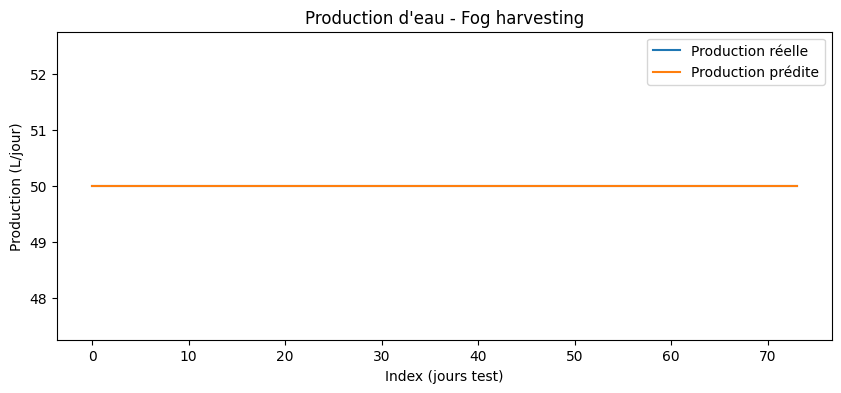


===== Hydropanel =====
✅ Modèle sauvegardé sous 'modele_hydropanel.pkl'
MAE: 0.018, RMSE: 0.023, R2: 0.999


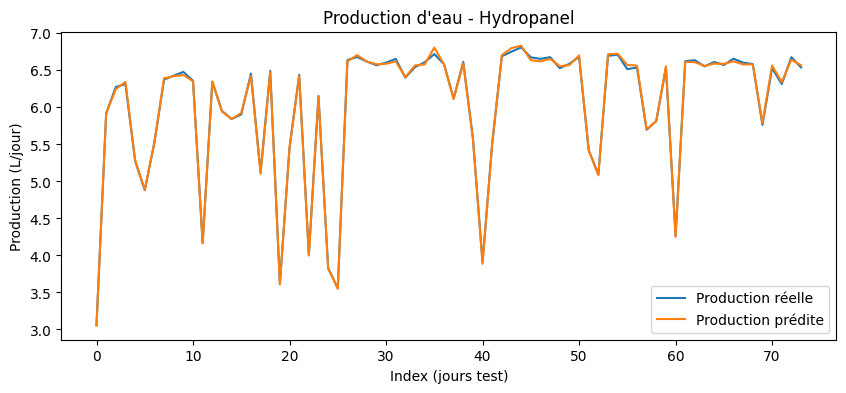


===== Agri-PV =====
✅ Modèle sauvegardé sous 'modele_agripv.pkl'
MAE: 0.027, RMSE: 0.034, R2: 0.999


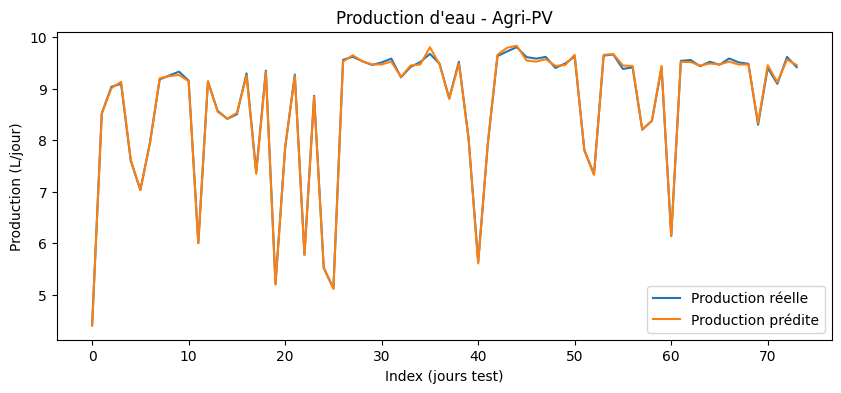


===== Condensation passive =====
✅ Modèle sauvegardé sous 'modele_condensation.pkl'
MAE: 0.000, RMSE: 0.000, R2: 1.000


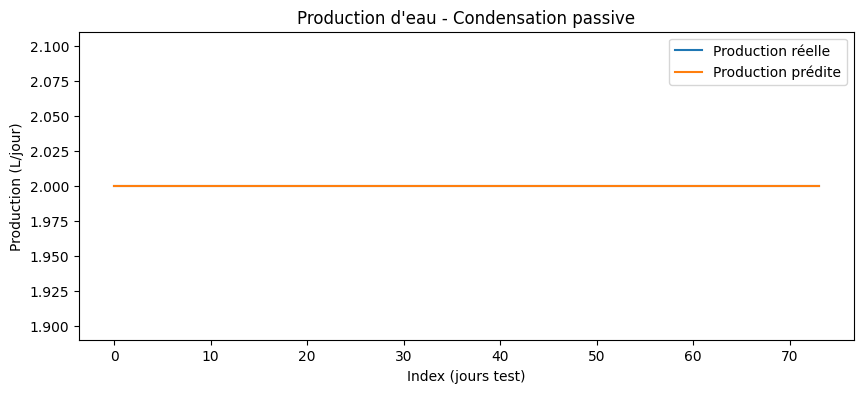


===== Synthèse des scores sur le test =====
              Technique       MAE      RMSE        R2
0        Fog harvesting  0.000000  0.000000  1.000000
1            Hydropanel  0.018397  0.023486  0.999326
2               Agri-PV  0.026804  0.034443  0.999301
3  Condensation passive  0.000000  0.000000  1.000000


In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données fusionnées
df = pd.read_csv("donnees_fusionnees.csv", parse_dates=["date"])

# Variables météo issues de la NASA Power
features = [
    "ALLSKY_SFC_SW_DWN",  # Irradiance solaire (équivalent shortwave_radiation_sum)
    "T2M_MAX",            # Température max
    "T2M_MIN",            # Température min
    "RH2M",               # Humidité relative
    "PRECTOTCORR",        # Précipitation
    "WS2M"                # Vent 2m
]

# Liste des techniques à traiter avec tes vrais noms de colonnes !
techniques = [
    ("Fog harvesting", "Fog_L_jour", "modele_fog.pkl"),
    ("Hydropanel", "Hydropanel_L_jour", "modele_hydropanel.pkl"),
    ("Agri-PV", "AgriPV_L_jour", "modele_agripv.pkl"),
    ("Condensation passive", "Condensation_L_jour", "modele_condensation.pkl")
]

resultats = []

for nom, col_target, nom_modele in techniques:
    print(f"\n===== {nom} =====")
    if col_target not in df.columns:
        print(f"Colonne '{col_target}' non trouvée, technique ignorée.")
        continue
    
    X = df[features]
    y = df[col_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    joblib.dump(model, nom_modele)
    print(f"✅ Modèle sauvegardé sous '{nom_modele}'")
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")
    
    resultats.append({
        "Technique": nom,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })
    
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values, label="Production réelle")
    plt.plot(y_pred, label="Production prédite")
    plt.title(f"Production d'eau - {nom}")
    plt.xlabel("Index (jours test)")
    plt.ylabel("Production (L/jour)")
    plt.legend()
    plt.show()

# Synthèse des scores
df_resultats = pd.DataFrame(resultats)
print("\n===== Synthèse des scores sur le test =====")
print(df_resultats)


In [32]:
import pandas as pd
import numpy as np

# 1. Charger les besoins en eau des cultures
df_besoins = pd.read_csv("besoins_eau_cultures.csv")

# 2. Charger le fichier des productions et coûts par technique
df_tech = pd.read_csv("production_cout_techniques.csv")

# 3. Choisir la culture, la surface et l’unité de surface
culture = "Blé"     # Mets la culture souhaitée ("Blé", "Olive", "Agrumes")
surface_ha = 1      # Surface en hectare (1 ha = 10 000 m²)
surface_m2 = surface_ha * 10000  # Conversion ha -> m²

# 4. Extraire besoin unitaire (L/jour/ha) de la culture
besoin_ha_jour = df_besoins[df_besoins["Culture"] == culture]["Besoins_L_jour_ha"].values[0]

# 5. Calculer besoin total (L/jour) pour la surface choisie
besoin_total = besoin_ha_jour * surface_ha
print(f"Besoins en eau pour {surface_ha} ha de {culture} : {besoin_total:.1f} L/jour")

# 6. Calculer le nombre d’unités et le coût pour chaque technique
resultats = []
for idx, row in df_tech.iterrows():
    technique = row["Technique"]
    prod_unit = row["Production_L_jour_unite"]
    cout_unit = row["Cout_unitaire_EUR"]

    nb_unites = np.ceil(besoin_total / prod_unit)
    cout_total = nb_unites * cout_unit

    resultats.append({
        "Technique": technique,
        "Production_unite (L/jour)": prod_unit,
        "Nombre_unites": int(nb_unites),
        "Cout_total (EUR)": cout_total
    })

df_resultats = pd.DataFrame(resultats)
print("\nSynthèse :")
print(df_resultats)


Besoins en eau pour 1 ha de Blé : 5000.0 L/jour

Synthèse :
              Technique  Production_unite (L/jour)  Nombre_unites  \
0        Fog harvesting                         50            100   
1            Hydropanel                          5           1000   
2               Agri-PV                          3           1667   
3  Condensation passive                          2           2500   

   Cout_total (EUR)  
0           40000.0  
1         2000000.0  
2         5001000.0  
3          250000.0  
